In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydicom import dcmread, read_file
from pydicom.data import get_testdata_file
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Ref
# https://www.kaggle.com/jeantirole/beginner-eda-siim-covid-19-detection/edit

In [2]:
!pip install python-gdcm
!pip install pylibjpeg-libjpeg

     |████████████████████████████████| 9.4 MB 523 kB/s eta 0:00:01     |█████████████▉                  | 4.1 MB 523 kB/s eta 0:00:11     |█████████████████████████▏      | 7.4 MB 523 kB/s eta 0:00:04
     |████████████████████████████████| 4.2 MB 861 kB/s eta 0:00:01


In [3]:
PATH = '/kaggle/input/siim-covid19-detection/'
submission = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv', index_col=None)
image_df = pd.read_csv('/kaggle/input/siim-covid19-detection/train_image_level.csv', index_col=None)
study_df = pd.read_csv('/kaggle/input/siim-covid19-detection/train_study_level.csv', index_col=None)
updated_train_df = pd.read_csv('/kaggle/input/updated-train-labels/updated_train_labels.csv', index_col=None)

sub_dect = pd.read_csv('../input/submission-detectron2/submission_dect.csv', index_col=None)
sub_yolo5 = pd.read_csv('../input/submission-efnb7yolo5/submission (6).csv',index_col=None)


pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
print(f"Train image level csv shape : {image_df.shape}\nTrain study level csv shape : {study_df.shape}")

Train image level csv shape : (6334, 4)
Train study level csv shape : (6054, 5)


In [14]:
sub_yolo5 = pd.read_csv('../input/submission-efnb7yolo5/submission (6).csv',index_col=None)
sub_yolo5_image = sub_yolo5[1214:].copy()
sub_yolo5_image['boxes'] = 0
sub_yolo5_image.head(2)

,id,PredictionString,boxes
1214,557a70442928_image,opacity 0.001011849963 2283 3061 2969 3320 opacity 0.001093860017 812 1679 1404 2231 opacity 0.001236920012 2023 1654 2636 2192 opacity 0.001305580023 812 733 1411 2081 opacity 0.001641270006 532 1686 945 2185 opacity 0.002115250099 612 1783 1205 2172 opacity 0.002143860096 2017 940 2676 2146 opacity 0.00234221993 2489 1414 3055 2257 opacity 0.003559109988 2210 1809 3135 2840 opacity 0.00369072007 2163 1738 2782 2140 opacity 0.005168910138 972 1582 1411 2094 opacity 0.006137850229 559 1459 1138 2146 opacity 0.008239749819 2410 1751 3115 2503 opacity 0.008834839799 652 1070 1291 2101 opacity 0.010559099726 2256 986 2982 2192 opacity 0.015899699181 2117 1459 2902 2192 opacity 0.020553600043 699 1543 1325 2107 opacity 0.040161099285 2250 1660 3035 2295 none 0.6767994 0 0 1 1,0
1215,36141cda67ad_image,opacity 0.001030919957 1176 1754 1896 2481 opacity 0.001286510029 1358 1876 1930 2365 opacity 0.001292229979 2998 333 3561 1155 opacity 0.001335139968 3329 1325 3884 2433 opacity 0.001340870047 1159 1366 1557 2059 opacity 0.001650810009 3155 788 3768 2406 opacity 0.001656529959 1333 204 1847 775 opacity 0.001938820002 2633 102 3486 965 opacity 0.001968380064 2782 1210 3569 2229 opacity 0.00199699006 1474 245 1921 666 opacity 0.002124790102 3246 1563 3677 2297 opacity 0.002775189932 2625 170 3594 1930 opacity 0.003192899982 1358 177 2087 1291 opacity 0.00432968 1209 1196 1979 2379 opacity 0.004848480225 1193 408 1665 1699 opacity 0.008872989565 1474 143 2087 809 opacity 0.009277340025 1168 952 1648 1998 opacity 0.009750369936 1226 95 2087 2093 opacity 0.011444100179 3197 1536 3768 2617 opacity 0.012313799933 1068 1217 1673 2413 opacity 0.019866900519 2824 496 3702 2352 opacity 0.074829101562 1135 585 1789 2291 opacity 0.112609997392 3014 1407 3710 2372 none 0.2986912 0 0 1 1,0


In [5]:
# let's find the dcm path 

import os
dir_file = [] 
bl_file = []
bl_dir_file = [ ]
for dirname, _, filenames in os.walk('../input/siim-covid19-detection/test'):
  for filename in filenames:
    dir_file.append(dirname)
    bl_file.append(filename)
    bl_dir_file.append((os.path.join(dirname, filename)))

In [6]:
AA = pd.DataFrame(data = list(bl_dir_file), columns = ['A'])
AA['B']=0

In [7]:
AA

,A,B
0,../input/siim-covid19-detection/test/2fb11712bc93/b056067b8455/a29c5a68b07b.dcm,0
1,../input/siim-covid19-detection/test/19c66935e737/41b28d4fa278/9850b5470fd6.dcm,0
2,../input/siim-covid19-detection/test/2fc50bf199cd/af8894793b6d/8d6dea06a032.dcm,0
3,../input/siim-covid19-detection/test/97c5d6eb413d/b543b2b0034b/dfc5c09a50bc.dcm,0
4,../input/siim-covid19-detection/test/593c3f815635/9f5ee1ac5c6c/7230234e120a.dcm,0
...,...,...
1258,../input/siim-covid19-detection/test/b12d2e5c39b7/dbe9ee02fe31/a43200bd5ceb.dcm,0
1259,../input/siim-covid19-detection/test/6484393291ea/7134da36e604/37bf83df1b86.dcm,0
1260,../input/siim-covid19-detection/test/6484393291ea/2ecb8f912c9f/b30d2aef985f.dcm,0
1261,../input/siim-covid19-detection/test/531aa20ff7c3/27416cfb11db/a37a362df0ac.dcm,0


In [8]:
for i in range(len(AA)):
  img_id = AA.iloc[i][0][-16:-4]
  AA['B'][i] = img_id +'_image'

AA.columns = ['file_path','id']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
AA

,file_path,id
0,../input/siim-covid19-detection/test/2fb11712bc93/b056067b8455/a29c5a68b07b.dcm,a29c5a68b07b_image
1,../input/siim-covid19-detection/test/19c66935e737/41b28d4fa278/9850b5470fd6.dcm,9850b5470fd6_image
2,../input/siim-covid19-detection/test/2fc50bf199cd/af8894793b6d/8d6dea06a032.dcm,8d6dea06a032_image
3,../input/siim-covid19-detection/test/97c5d6eb413d/b543b2b0034b/dfc5c09a50bc.dcm,dfc5c09a50bc_image
4,../input/siim-covid19-detection/test/593c3f815635/9f5ee1ac5c6c/7230234e120a.dcm,7230234e120a_image
...,...,...
1258,../input/siim-covid19-detection/test/b12d2e5c39b7/dbe9ee02fe31/a43200bd5ceb.dcm,a43200bd5ceb_image
1259,../input/siim-covid19-detection/test/6484393291ea/7134da36e604/37bf83df1b86.dcm,37bf83df1b86_image
1260,../input/siim-covid19-detection/test/6484393291ea/2ecb8f912c9f/b30d2aef985f.dcm,b30d2aef985f_image
1261,../input/siim-covid19-detection/test/531aa20ff7c3/27416cfb11db/a37a362df0ac.dcm,a37a362df0ac_image


In [15]:
new_sub_yolo5_image = pd.merge(sub_yolo5_image,AA, how='outer', on ='id')

In [16]:
new_sub_yolo5_image.head(2)

,id,PredictionString,boxes,file_path
0,557a70442928_image,opacity 0.001011849963 2283 3061 2969 3320 opacity 0.001093860017 812 1679 1404 2231 opacity 0.001236920012 2023 1654 2636 2192 opacity 0.001305580023 812 733 1411 2081 opacity 0.001641270006 532 1686 945 2185 opacity 0.002115250099 612 1783 1205 2172 opacity 0.002143860096 2017 940 2676 2146 opacity 0.00234221993 2489 1414 3055 2257 opacity 0.003559109988 2210 1809 3135 2840 opacity 0.00369072007 2163 1738 2782 2140 opacity 0.005168910138 972 1582 1411 2094 opacity 0.006137850229 559 1459 1138 2146 opacity 0.008239749819 2410 1751 3115 2503 opacity 0.008834839799 652 1070 1291 2101 opacity 0.010559099726 2256 986 2982 2192 opacity 0.015899699181 2117 1459 2902 2192 opacity 0.020553600043 699 1543 1325 2107 opacity 0.040161099285 2250 1660 3035 2295 none 0.6767994 0 0 1 1,0,../input/siim-covid19-detection/test/795051254905/2d4fb41c0707/557a70442928.dcm
1,36141cda67ad_image,opacity 0.001030919957 1176 1754 1896 2481 opacity 0.001286510029 1358 1876 1930 2365 opacity 0.001292229979 2998 333 3561 1155 opacity 0.001335139968 3329 1325 3884 2433 opacity 0.001340870047 1159 1366 1557 2059 opacity 0.001650810009 3155 788 3768 2406 opacity 0.001656529959 1333 204 1847 775 opacity 0.001938820002 2633 102 3486 965 opacity 0.001968380064 2782 1210 3569 2229 opacity 0.00199699006 1474 245 1921 666 opacity 0.002124790102 3246 1563 3677 2297 opacity 0.002775189932 2625 170 3594 1930 opacity 0.003192899982 1358 177 2087 1291 opacity 0.00432968 1209 1196 1979 2379 opacity 0.004848480225 1193 408 1665 1699 opacity 0.008872989565 1474 143 2087 809 opacity 0.009277340025 1168 952 1648 1998 opacity 0.009750369936 1226 95 2087 2093 opacity 0.011444100179 3197 1536 3768 2617 opacity 0.012313799933 1068 1217 1673 2413 opacity 0.019866900519 2824 496 3702 2352 opacity 0.074829101562 1135 585 1789 2291 opacity 0.112609997392 3014 1407 3710 2372 none 0.2986912 0 0 1 1,0,../input/siim-covid19-detection/test/0d476d070d71/360c62464c4c/36141cda67ad.dcm


In [18]:
# sub_yolo5_image
## box 정리코드~~~~~ 

for k in range(len(new_sub_yolo5_image)):
    sample01 = new_sub_yolo5_image.iloc[k][1]
    all_boxes= []
    box_idxs = []
    for i in range( len( sample01.split(' ') )     ):
        if i % 6 == 2:
            box_idxs.append(i)

        elif i % 6 ==3:
            box_idxs.append(i)

        elif i % 6 ==4:
            box_idxs.append(i)

        elif i % 6 ==5:
            box_idxs.append(i)
    box_idxs

    boxes = [ ]
    for i in box_idxs:
        boxes.append( sample01.split(' ')[i] )

    # len(boxes) = 24 
    #print(boxes)


    bl_boxs= []
    for j in range(len(boxes)):
        if (j+1) % 4 ==1 :
            a = j
            #print(a)
            s_box = boxes[a:a+4]
            bl_boxs.append(s_box)

    all_boxes.append(bl_boxs)        
    #print(bl_boxs)
    #print(all_boxes)
    sample01

    new_sub_yolo5_image['boxes'][k] = bl_boxs.copy()
    
# box 정리해씀 

In [20]:
new_sub_yolo5_image.head(1)

,id,PredictionString,boxes,file_path
0,557a70442928_image,opacity 0.001011849963 2283 3061 2969 3320 opacity 0.001093860017 812 1679 1404 2231 opacity 0.001236920012 2023 1654 2636 2192 opacity 0.001305580023 812 733 1411 2081 opacity 0.001641270006 532 1686 945 2185 opacity 0.002115250099 612 1783 1205 2172 opacity 0.002143860096 2017 940 2676 2146 opacity 0.00234221993 2489 1414 3055 2257 opacity 0.003559109988 2210 1809 3135 2840 opacity 0.00369072007 2163 1738 2782 2140 opacity 0.005168910138 972 1582 1411 2094 opacity 0.006137850229 559 1459 1138 2146 opacity 0.008239749819 2410 1751 3115 2503 opacity 0.008834839799 652 1070 1291 2101 opacity 0.010559099726 2256 986 2982 2192 opacity 0.015899699181 2117 1459 2902 2192 opacity 0.020553600043 699 1543 1325 2107 opacity 0.040161099285 2250 1660 3035 2295 none 0.6767994 0 0 1 1,"[[2283, 3061, 2969, 3320], [812, 1679, 1404, 2231], [2023, 1654, 2636, 2192], [812, 733, 1411, 2081], [532, 1686, 945, 2185], [612, 1783, 1205, 2172], [2017, 940, 2676, 2146], [2489, 1414, 3055, 2257], [2210, 1809, 3135, 2840], [2163, 1738, 2782, 2140], [972, 1582, 1411, 2094], [559, 1459, 1138, 2146], [2410, 1751, 3115, 2503], [652, 1070, 1291, 2101], [2256, 986, 2982, 2192], [2117, 1459, 2902, 2192], [699, 1543, 1325, 2107], [2250, 1660, 3035, 2295], [0, 0, 1, 1]]",../input/siim-covid19-detection/test/795051254905/2d4fb41c0707/557a70442928.dcm


In [21]:
def draw_imgnbox_test(image_id):

  imgid = image_id
  PATH = '/kaggle/input/siim-covid19-detection/'
  file_path = new_sub_yolo5_image.loc[ new_sub_yolo5_image.id == imgid].file_path[0]
  dicom = read_file(file_path, stop_before_pixels=False)
  img=dicom.pixel_array
  print(type(img), img.shape)

  num_boxes = len(new_sub_yolo5_image.loc[new_sub_yolo5_image.id==imgid]['boxes'][0])
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.imshow(img, cmap="gray")

  for i in range(num_boxes):
    xmin, ymin, xmax, ymax = new_sub_yolo5_image.loc[new_sub_yolo5_image.id==imgid]['boxes'][0][i]
    print(xmin, ymin, xmax, ymax )
    rect = patches.Rectangle((int(xmin), int(ymin)), int(xmax)-int(xmin), int(ymax)-int(ymin), linewidth=1.5, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

  plt.show()

<class 'numpy.ndarray'> (3320, 3408)
2283 3061 2969 3320
812 1679 1404 2231
2023 1654 2636 2192
812 733 1411 2081
532 1686 945 2185
612 1783 1205 2172
2017 940 2676 2146
2489 1414 3055 2257
2210 1809 3135 2840
2163 1738 2782 2140
972 1582 1411 2094
559 1459 1138 2146
2410 1751 3115 2503
652 1070 1291 2101
2256 986 2982 2192
2117 1459 2902 2192
699 1543 1325 2107
2250 1660 3035 2295
0 0 1 1


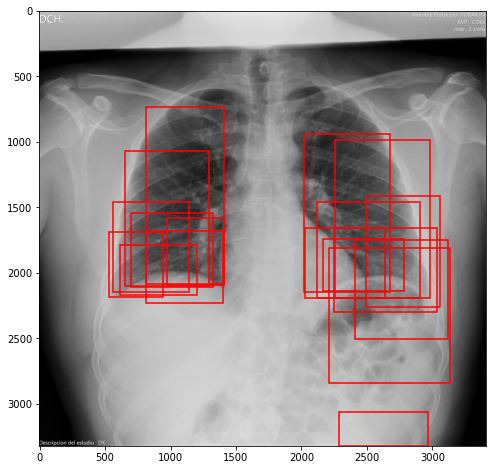

In [22]:
draw_imgnbox_test('557a70442928_image')